
Function: Sphere
BPSO: 9.8253e-02
HPSO: 9.0425e-02
TPSO: 1.2500e-01
LCGPSO: 1.4460e-01
MCGPSO: 1.6111e-01

Function: Ackley
BPSO: 3.5471e+00
HPSO: 1.9982e+01
TPSO: 1.8499e+01
LCGPSO: 5.6433e+00
MCGPSO: 3.4723e+00

Function: Salomon
BPSO: 1.4799e+00
HPSO: 1.3699e+00
TPSO: 1.4899e+00
LCGPSO: 1.5199e+00
MCGPSO: 1.5799e+00


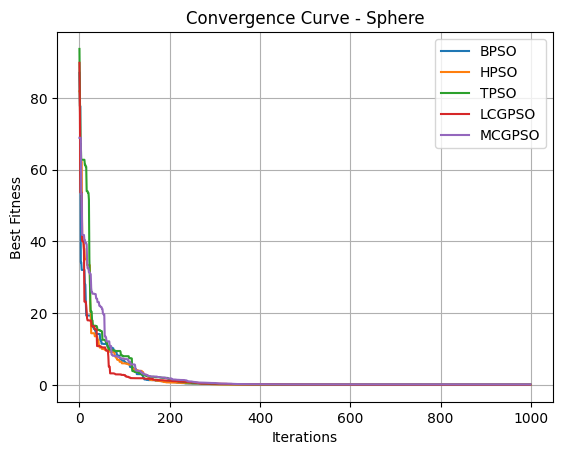

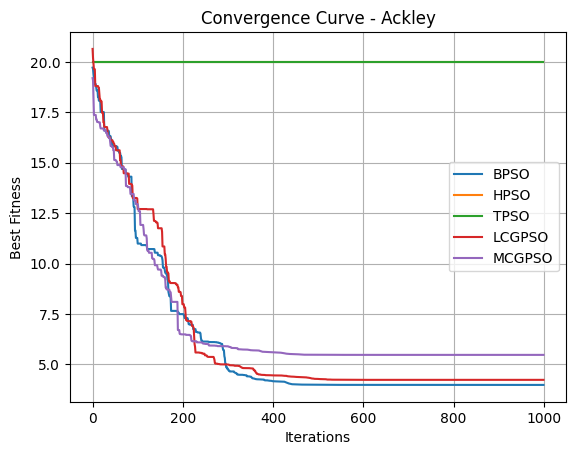

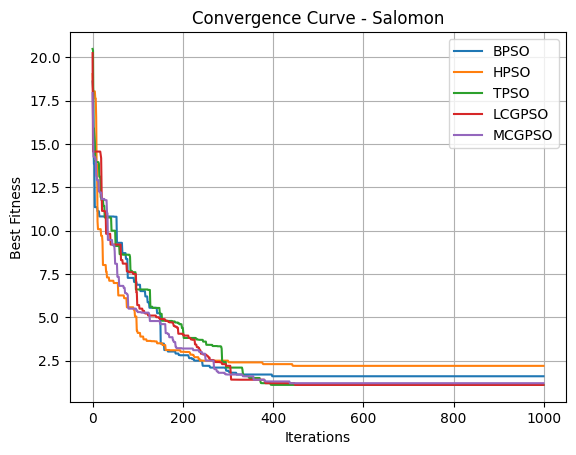


✅ Experiments Completed Successfully


In [3]:
# =========================================
# PSO with Different Initialization Methods
# Reconstructed from Thesis Methodology
# Google Colab Compatible
# =========================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, f_oneway, ttest_ind

# =========================
# 1. Benchmark Functions
# =========================

def noisy_function(x):
    return sum((i+1)*x[i]**2 for i in range(len(x))) + np.random.rand()

def salomon(x):
    s = np.sum(x**2)
    return 1 - np.cos(2*np.pi*np.sqrt(s)) + 0.1*np.sqrt(s)

def sum_diff_power(x):
    return sum(abs(x[i])**(i+2) for i in range(len(x)))

def rotated_hyper_ellipsoid(x):
    return sum((np.sum(x[:i+1]))**2 for i in range(len(x)))

def axis_parallel_hyper_ellipsoid(x):
    return sum((i+1)*x[i]**2 for i in range(len(x)))

def schwefel_1_2(x):
    return sum((np.sum(x[:i+1]))**2 for i in range(len(x)))

def ackley(x):
    n = len(x)
    return (-20*np.exp(-0.2*np.sqrt(np.sum(x**2)/n))
            - np.exp(np.sum(np.cos(2*np.pi*x))/n)
            + 20 + np.e)

def sphere(x):
    return np.sum(x**2)

def schumer_stieglitz(x):
    return np.sum(x**4)

# =========================
# 2. Initialization Methods
# =========================

def random_init(n, d, bounds):
    return np.random.uniform(bounds[0], bounds[1], (n, d))

def halton_init(n, d, bounds, scramble=False):
    sampler = qmc.Halton(d=d, scramble=scramble)
    sample = sampler.random(n)
    return qmc.scale(sample, bounds[0], bounds[1])

def torus_init(n, d, bounds):
    alpha = np.sqrt(2)
    points = np.zeros((n, d))
    for i in range(n):
        for j in range(d):
            points[i, j] = (i * alpha * (j+1)) % 1
    return bounds[0] + points * (bounds[1] - bounds[0])

def lcg_init(n, d, bounds, seed=1):
    m, a, c = 2**31 - 1, 1103515245, 12345
    x = seed
    data = np.zeros((n, d))
    for i in range(n):
        for j in range(d):
            x = (a*x + c) % m
            data[i, j] = x / m
    return bounds[0] + data*(bounds[1] - bounds[0])

def mcg_init(n, d, bounds, seed=1):
    m, a = 2**31 - 1, 16807
    x = seed
    data = np.zeros((n, d))
    for i in range(n):
        for j in range(d):
            x = (a*x) % m
            data[i, j] = x / m
    return bounds[0] + data*(bounds[1] - bounds[0])

# =========================
# 3. PSO Core Algorithm
# =========================

class PSO:
    def __init__(self, func, bounds, dim, init_method,
                 n_particles=40, max_iter=1000,
                 w_max=0.9, w_min=0.4, c1=2.0, c2=2.0):

        self.func = func
        self.bounds = bounds
        self.dim = dim
        self.n = n_particles
        self.max_iter = max_iter
        self.w_max, self.w_min = w_max, w_min
        self.c1, self.c2 = c1, c2

        self.X = init_method(self.n, self.dim, bounds)
        self.V = np.zeros_like(self.X)

        self.pbest = self.X.copy()
        self.pbest_val = np.array([func(x) for x in self.X])

        idx = np.argmin(self.pbest_val)
        self.gbest = self.pbest[idx].copy()
        self.gbest_val = self.pbest_val[idx]

    def optimize(self):
        history = []

        for t in range(self.max_iter):
            w = self.w_max - (self.w_max - self.w_min)*(t/self.max_iter)

            for i in range(self.n):
                r1, r2 = np.random.rand(), np.random.rand()
                self.V[i] = (w*self.V[i]
                             + self.c1*r1*(self.pbest[i] - self.X[i])
                             + self.c2*r2*(self.gbest - self.X[i]))

                self.X[i] += self.V[i]
                self.X[i] = np.clip(self.X[i], self.bounds[0], self.bounds[1])

                fit = self.func(self.X[i])
                if fit < self.pbest_val[i]:
                    self.pbest[i] = self.X[i].copy()
                    self.pbest_val[i] = fit

            idx = np.argmin(self.pbest_val)
            if self.pbest_val[idx] < self.gbest_val:
                self.gbest = self.pbest[idx].copy()
                self.gbest_val = self.pbest_val[idx]

            history.append(self.gbest_val)

        return self.gbest_val, history

# =========================
# 4. Experiment Setup
# =========================

functions = {
    "Sphere": (sphere, (-5.12, 5.12)),
    "Ackley": (ackley, (-35, 35)),
    "Salomon": (salomon, (-100, 100))
}

initializers = {
    "BPSO": random_init,
    "HPSO": lambda n,d,b: halton_init(n,d,b,False),
    "TPSO": torus_init,
    "LCGPSO": lcg_init,
    "MCGPSO": mcg_init
}

dims = [10, 20, 30]
runs = 10
iterations = 1000

# =========================
# 5. Run Experiments
# =========================

results = {}
histories = {}

for fname, (func, bounds) in functions.items():
    print(f"\nFunction: {fname}")
    results[fname] = {}
    histories[fname] = {}

    for method, init in initializers.items():
        vals = []
        last_history = None

        for _ in range(runs):
            pso = PSO(func, bounds, 30, init, max_iter=iterations)
            best, hist = pso.optimize()
            vals.append(best)
            last_history = hist

        results[fname][method] = np.mean(vals)
        histories[fname][method] = last_history

        print(f"{method}: {results[fname][method]:.4e}")

# =========================
# 6. Convergence Plots
# =========================

for fname in histories:
    plt.figure()
    for method in histories[fname]:
        plt.plot(histories[fname][method], label=method)
    plt.xlabel("Iterations")
    plt.ylabel("Best Fitness")
    plt.title(f"Convergence Curve - {fname}")
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n✅ Experiments Completed Successfully")
